# Compute regional means on the POP grid

In [1]:
# magic function to set matplotlib backend: 
# http://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline

#-- module imports
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import matplotlib.pyplot as plt

### read data for each case

In [2]:
%%time
# -- specify cases as OrderedDict with with shortname as key and subdictionaries for case attributes
case_def = OrderedDict([
    ('005', {'long_name':'g.e20b07.G1850ECO_CPLHIST.f09_g17.eval.221.005'}),
    ('005b',{'long_name':'g.e20b07.G1850ECO_CPLHIST.f09_g17.eval.221.005b'})])

stream = 'pop.h'

histpath_template = ('/glade/scratch/klindsay/archive/{casename}/ocn/hist/'
                     '{casename}.{stream}.????.nc')


xr_mfopen_args = {'decode_times':False,
                  'decode_coords':False,
                  'data_vars':'minimal'}

#-- loop over cases, create a list of datasets
dss = []
for i,(casename,case_attrs) in enumerate(case_def.items()):
    print('reading files for {0}'.format(casename))
    
    #-- get files
    histfiles = sorted(glob(histpath_template.format(casename=case_attrs['long_name'],
                                                     stream=stream)))
    #-- open dataset
    ds = xr.open_mfdataset(histfiles,**xr_mfopen_args)

    #-- strip out non-time-varying variables
    if i == 0:
        grid_vars = [v for v in ds.variables if 'time' not in ds[v].dims]
        grid = ds.drop([v for v in ds.variables if v not in grid_vars])
    ds = ds.drop(grid_vars)
    
    #-- append
    dss.append(ds)

#-- create a single dataset with 'case' dimension
ds = xr.concat(dss,dim='case')

#-- put the grid vars back
ds = xr.merge((ds,grid))

print('ds size {:0.2f}GB\n'.format(ds.nbytes / 1e9))
ds.info()

reading files for 005
reading files for 005b
ds size 1303.94GB

xarray.Dataset {
dimensions:
	case = 2 ;
	d2 = 2 ;
	nlat = 384 ;
	nlon = 320 ;
	time = 90 ;
	z_t = 60 ;
	z_t_150m = 15 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	z_w_top = 60 ;

variables:
	float64 z_w_bot(z_w_bot) ;
	float64 z_t(z_t) ;
	float64 z_t_150m(z_t_150m) ;
	float64 z_w_top(z_w_top) ;
	float64 time(time) ;
		time:long_name = time ;
		time:units = days since 0000-01-01 00:00:00 ;
		time:bounds = time_bound ;
		time:calendar = noleap ;
	float64 time_bound(case, time, d2) ;
		time_bound:long_name = boundaries for time-averaging interval ;
		time_bound:units = days since 0000-01-01 00:00:00 ;
	float64 UVEL(case, time, z_t, nlat, nlon) ;
		UVEL:long_name = Velocity in grid-x direction ;
		UVEL:units = centimeter/s ;
		UVEL:coordinates = ULONG ULAT z_t time ;
		UVEL:grid_loc = 3221 ;
		UVEL:cell_methods = time: mean ;
	float64 UVEL2(case, time, z_t, nlat, nlon) ;
		UVEL2:long_name = Velocity**2 in grid-x direction ;
		UVEL2:units =

### manually handle time
xarray and numpy don't support non-standard calendars yet, but netcdftime does.  Since we're dealing with annual means in this example, just compute the year.

In [3]:
%%time
from netcdftime import utime
cdftime = utime(ds.time.attrs['units'],
                calendar=ds.time.attrs['calendar'])
time = cdftime.num2date(ds.time)
ds['year'] = xr.DataArray(np.array([d.year for d in time]),dims='time')
ds.year

CPU times: user 112 ms, sys: 10 ms, total: 122 ms
Wall time: 103 ms


In [4]:
%%time
grid['KMT'] = grid.KMT.fillna(0)
grid['TAREA'] = grid.TAREA.fillna(0.)
nk = len(grid.z_t)
nj = grid.KMT.shape[0]
ni = grid.KMT.shape[1]

CPU times: user 25 ms, sys: 1 ms, total: 26 ms
Wall time: 25.6 ms


### execute [`compute`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.compute.html#xarray.Dataset.compute) method on the grid info to load into memory

In [5]:
%%time
grid = grid.compute()

CPU times: user 4 ms, sys: 1e+03 µs, total: 5 ms
Wall time: 4.94 ms


### read a region mask

<xarray.DataArray 'REGION_MASK' (nlat: 384, nlon: 320)>
array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  1.,   1.,   1., ...,   0.,   0.,   0.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    basin index number (signed integers)
    coordinates:  TLONG TLAT
CPU times: user 161 ms, sys: 7 ms, total: 168 ms
Wall time: 164 ms


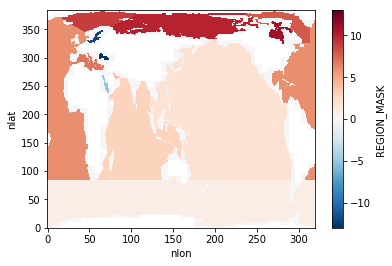

In [6]:
%%time
rmask = grid.REGION_MASK
print(rmask)
rmask.plot()

### turn region mask into a 3D field

In [7]:
region = np.unique(rmask)
region = region[~np.isnan(region)]
nrgn = len(region)
rmask3d = xr.DataArray(np.zeros((nrgn,)+rmask.shape),
                       dims=('region','nlat','nlon'))
for i,r in enumerate(region):
    rmask3d.values[i,:,:] = np.where(rmask==r,1,0)

print(region)    

[-13. -12.  -5.   0.   1.   2.   3.   4.   6.   7.   8.   9.  10.  11.]


### generate a 3D mask set to 1.0 for valid ocean points and 0. elsewhere

<xarray.DataArray (z_t: 60, nlat: 384, nlon: 320)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       ..., 
       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
Dimensions without coordinates: nlat, nlon


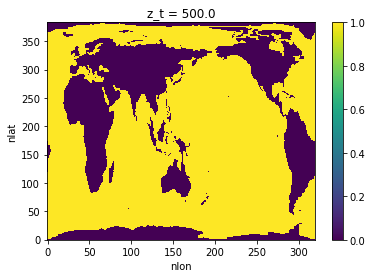

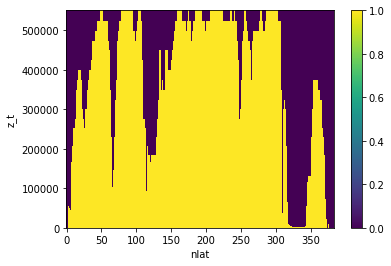

In [8]:
#-- make 3D array of 0:km 
ONES = xr.DataArray(np.ones((nk,nj,ni)),dims=('z_t','nlat','nlon'),coords={'z_t':grid.z_t})
K = xr.DataArray(np.arange(0,len(grid.z_t)),dims=('z_t'))
MASK = K * ONES
MASK = MASK.where(MASK <= grid.KMT-1)
MASK.values = np.where(MASK.notnull(),1.,0.)

plt.figure()
MASK.isel(z_t=0).plot()

plt.figure()
MASK.isel(nlon=200).plot()

print(MASK)

### generate a 3D volume field

CPU times: user 339 ms, sys: 46 ms, total: 385 ms
Wall time: 384 ms


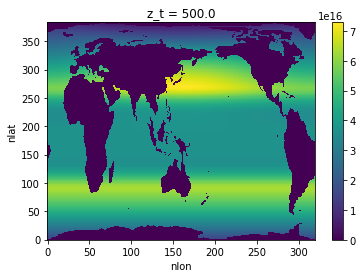

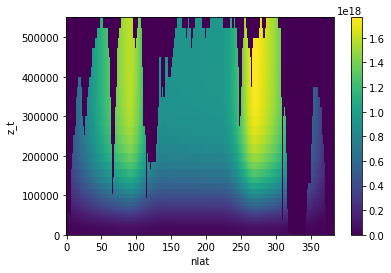

In [9]:
%%time
VOL = grid.dz * grid.TAREA * MASK

plt.figure()
VOL.isel(z_t=0).plot()

plt.figure()
VOL.isel(nlon=200).plot()

In [10]:
MASKED_VOL = VOL * rmask3d
MASKED_VOL

<xarray.DataArray (z_t: 60, nlat: 384, nlon: 320, region: 14)>
array([[[[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]],

        ..., 
        [[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]]],


       ..., 
       [[[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]],

        ..., 
        [[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]]]])
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 ...
Dimensions without coordinates: nlat, nlon, region

In [11]:
MASKED_AREA = MASK * grid.TAREA * rmask3d
MASKED_AREA

<xarray.DataArray (z_t: 60, nlat: 384, nlon: 320, region: 14)>
array([[[[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]],

        ..., 
        [[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]]],


       ..., 
       [[[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]],

        ..., 
        [[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]]]])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
Dimensions without coordinates: nlat, nlon, region

### Set up to compute regional averages and regional integrals

First step is to get volume and area weights

In [12]:
%%time
region_mean_vars = ['FG_CO2','Jint_100m_Ctot']
avg_over_dims = ['z_t','nlat','nlon']

vol_sum = MASKED_VOL.sum(dim=avg_over_dims)
vol_wgt = MASKED_VOL / vol_sum

area_sum = MASKED_AREA.sum(dim=avg_over_dims)
area_wgt = MASKED_AREA / area_sum
print(vol_sum)
print(area_sum)

<xarray.DataArray (region: 14)>
array([  5.503133e+20,   1.885734e+19,   1.582821e+20,   0.000000e+00,
         3.652833e+23,   5.427556e+23,   1.583646e+23,   8.221922e+18,
         2.339507e+23,   3.748362e+21,   3.154612e+21,   4.085865e+21,
         1.292167e+22,   1.210896e+20])
Dimensions without coordinates: region
<xarray.DataArray (region: 14)>
array([  1.556277e+17,   1.885734e+16,   1.094981e+17,   0.000000e+00,
         5.007022e+19,   7.180552e+19,   2.241670e+19,   8.221922e+15,
         3.200589e+19,   9.520254e+17,   7.919306e+17,   1.003442e+18,
         2.858631e+18,   1.201163e+17])
Dimensions without coordinates: region
CPU times: user 2.27 s, sys: 1.08 s, total: 3.34 s
Wall time: 3.34 s


In [ ]:
%%time
ds_ravg = xr.Dataset()
for v in region_mean_vars:
    avg_over_dims_v = [k for k in avg_over_dims if k in ds[v].dims]

    if not avg_over_dims_v: 
        raise ValueError('Unexpected dimensions for variable {0}'.format(v))
    if any(['z_' in d for d in ds[v].dims]):    
        ds_ravg[v] = (ds[v] * vol_wgt).sum(dim=avg_over_dims)
    else:
        ds_ravg[v] = (ds[v] * area_wgt).sum(dim=avg_over_dims)


CPU times: user 7.07 s, sys: 0 ns, total: 7.07 s
Wall time: 7.05 s


Execute `compute` so data persists in memory

In [ ]:
%%time
ds_ravg = ds_ravg.compute()
print(ds_ravg)

In [ ]:
%%time
for v in region_mean_vars:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i,(casename,case_attrs) in enumerate(case_def.items()):
        ax.plot(ds.year,ds_ravg[v].isel(region=4,case=i),'-',label=casename)

    ax.set_title(v)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)